# **Práctica 2**
**Autores:** José María García Ortiz, Levi Malest Villareal y Ana Gil Molina

In [2]:
# Cargamos aquí las librerías que vamos a utilizar:


import skimage.transform as transform
import skimage.exposure as exposure
import skimage.filters as filters
import skimage.color as color
import skimage.morphology as morphology
import skimage.restoration as restoration


import random
import numpy as np
import math
import matplotlib.pyplot as plt
import skimage
import cv2
import matplotlib

from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi
from ipywidgets import FloatSlider, interact, fixed

# from google.colab.patches import cv2_imshow
from skimage import measure

## Código para leer ficheros desde Drive

In [ ]:
from google.colab import drive
import os
import shutil
import gdown
import zipfile


# IDs de los archivos compartidos (reemplaza con los IDs de tus archivos .zip)
file_ids = ['1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH', '1U3l67Tw6-KsrPI9AQ9NullORE9U1G7UQ']  # Cambia estos IDs por los de tus archivos

    #https://drive.google.com/file/d/1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH/view?usp=sharing

# Nombres locales para los archivos descargados y descomprimidos
download_paths = ['/ComputerVisionFiles.zip', '/stereopairs.zip']
extract_paths = ['', '']

# Descargar y descomprimir cada archivo
for file_id, download_path, extract_path in zip(file_ids, download_paths, extract_paths):
    # Descargar archivo
    gdown.download(f'https://drive.google.com/uc?id={file_id}', download_path, quiet=False)

    # Descomprimir el archivo ZIP
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Archivos descomprimidos en '{extract_path}'")

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio OP2B (0.3 pts)</strong></div>

- Crear un segundo algoritmo, resultado de la modificación del obligatorio para rectas, que
 aplique RANSAC para la detección de círculos de imagen, en lugar de rectas. Ilustrarlo también con un ejemplo práctico resuelto.

In [3]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

### - Definición de funciones auxiliares


In [4]:
def fit_circle(points):
    A = np.array([
        [points[0][0], points[0][1], 1],
        [points[1][0], points[1][1], 1],
        [points[2][0], points[2][1], 1]
    ])
    
    B = np.array([
        [points[0][0]**2 + points[0][1]**2],
        [points[1][0]**2 + points[1][1]**2],
        [points[2][0]**2 + points[2][1]**2]
    ])
    
    C = np.linalg.solve(A, B)
    center_x = C[0][0] / 2
    center_y = C[1][0] / 2
    radius = np.sqrt((C[0][0]**2 + C[1][0]**2) / 4 + C[2][0])
    
    return (center_x, center_y), radius

def distance(point, circle):
    center, radius = circle
    return np.abs(np.sqrt((point[0] - center[0])**2 + (point[1] - center[1])**2) - radius)

def are_collinear(p1, p2, p3):
    area = p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1])
    return np.isclose(area, 0)

def ransac_circle_detection(data_points, num_iterations=1000, distance_threshold=5, min_radius=0, max_radius=float('inf')):
    best_circle = None
    max_inliers = 0
    best_inliers = []

    for _ in range(num_iterations):
        sample_points = random.sample(data_points.tolist(), 3)
        
        if are_collinear(*sample_points):
            continue
        
        circle = fit_circle(sample_points)
        center, radius = circle
        
        # Comprobar que el radio se encuentre dentro del rango especificado
        if radius < min_radius or radius > max_radius:
            continue

        inliers = []
        for point in data_points:
            if distance(point, circle) < distance_threshold:
                inliers.append(point)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_circle = circle
            best_inliers = inliers

    return best_circle, max_inliers, best_inliers

def detect_multiple_circles(data_points, max_circles=5, distance_threshold=5, min_radius=0, max_radius=float('inf')):
    circles = []
    remaining_points = data_points.copy()

    for _ in range(max_circles):
        best_circle, inlier_count, inliers = ransac_circle_detection(
            remaining_points,
            num_iterations=1000,
            distance_threshold=distance_threshold,
            min_radius=min_radius,
            max_radius=max_radius
        )

        if best_circle is not None and inlier_count > 0:
            circles.append((best_circle, inlier_count))
            inliers_set = set(map(tuple, inliers))
            remaining_points = np.array([p for p in remaining_points if tuple(p) not in inliers_set])

        else:
            break

    return circles


### - Prueba de concepto

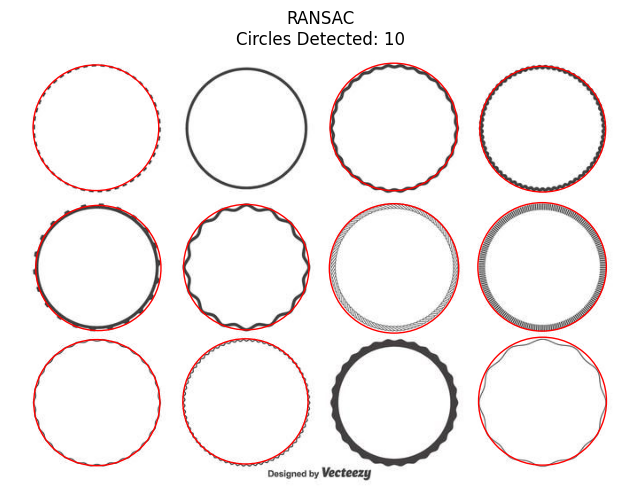

In [ ]:
# Carga de la imagen
image_path = 'ComputerVisionFiles/circulos2.jpg'  
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

# Buscamos los contornos
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Almacenar los puntos de controno
data_points = []
for contour in contours:
    for point in contour:
        data_points.append(tuple(point[0]))

data_points = np.array(data_points)

# Detectar míltiples círculos con las restricciónes espeficicadas de los radios
min_radius = 10  # radio mínimo
max_radius = 80  # radio máximo
detected_circles = detect_multiple_circles(data_points, max_circles=10, distance_threshold=5, min_radius=min_radius, max_radius=max_radius)

# Mostrar resultados
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

for circle, inlier_count in detected_circles:
    center, radius = circle
    circle_patch = plt.Circle(center, radius, color='red', fill=False, label='Detected Circle')
    plt.gca().add_artist(circle_patch)

plt.title(f'RANSAC\nCircUlos Detectados: {len(detected_circles)}')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.axis('off')
#plt.legend()
plt.show()

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio OP2D (0.3 pts)</strong></div>

- Resolver cualquiera de los casos anteriores (rectas/círculos individuales/múltiples) mediante
 cualquiera de las variantes de la transformada de Hough estudiadas en clase.

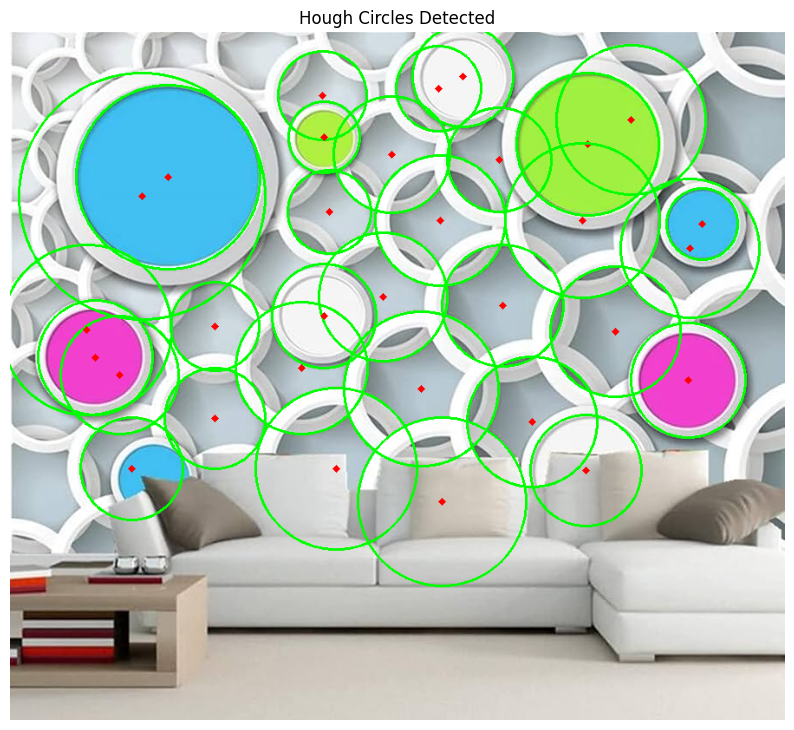

In [ ]:
# Cargamos la imagen
image = cv2.imread('ComputerVisionFiles/decoracion.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar desenfoque gaussiano para reducir el ruido
blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Detectar círculos usando HoughCircles
circles = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1,               # Relación inversa de la resolución del acumulador a la resolución de la imagen
    minDist=30,        # Distancia mínima entre centros detectados
    param1=100,        # Umbral superior para el detector de bordes Canny
    param2=70,         # Umbral para la detección del centro
    minRadius=0,       # Radio mínimo
    maxRadius=0        # Radio máximo
)

# Dibujar los círculos detectados
if circles is not None:
    circles = np.uint16(np.around(circles))  # Convertir a enteros
    for i in circles[0, :]:
        # Dibujar el círculo
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Dibujar el centro del círculo
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)



#  Convertir la imagen del formato BGR a RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plotear resultados con Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Hough Circles Detected')
plt.show()